# Part 2 - Data Preprocessing and Modeling

This notebook will focus on preprocessing data to bring them optimal size and format using data augmentation parameters. Once the preprocessing complete, I will train various Tensorflow Keras "sequential" and ""convolutional" networks as well as pre-trained models to sample transfer learning to come up with best results. As the classes are imbalanced, my success metrics should be Precision and Recall. Specifically Recall score is the most important as our goal is to focus on minimizing false negative rates to not classify a patient as healthy while in fact they have pneumonia.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from glob import glob
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# For reproducibility
np.random.seed(42)

In [2]:
train_dir = r'D:\Class\Notes\Sem 6th\pneumonia_detection_CNN-master\data\chest_xray\train'
test_dir = r'D:\Class\Notes\Sem 6th\pneumonia_detection_CNN-master\data\chest_xray\test'


In [3]:


# Define data generators for training and testing with augmentation and rescaling
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.25,
    height_shift_range=0.25,
    rescale=1./255,
    shear_range=0.25,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)


In [4]:
# Create directory iterators
batch_size = 16
target_size = (224, 224)  

train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure data is not shuffled for confusion matrix
)

Found 5216 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


In [5]:
# Model #1: Simple CNN
model1 = Sequential()
model1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=train_set.image_shape))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))#rectified linear unit 
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(rate=0.25))
model1.add(Flatten())
model1.add(Dense(units=256, activation='relu'))
model1.add(Dropout(rate=0.25))
model1.add(Dense(units=3, activation='softmax'))

In [6]:
# Compile the model
opt = SGD(lr=0.01)
model1.compile(optimizer='adam',
               loss='categorical_crossentropy',  # Use categorical_crossentropy for one-hot encoded labels
               metrics=['accuracy'])

In [7]:
# Summary of the model
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 54, 54, 64)        0         
                                                                 
 flatten (Flatten)           (None, 186624)            0

In [11]:
# Define early stopping
early_stopping_monitor = EarlyStopping(patience=5, 
                                       monitor="val_accuracy", 
                                       mode="max", 
                                       verbose=2)

In [21]:
# Fit model on training data
history = model1.fit(train_set,
                     validation_data=test_set,
                     epochs=10,
                     steps_per_epoch=len(train_set),
                     validation_steps=len(test_set),
                     shuffle=False,
                     verbose=2)#output one line per epoch, showing the progress of training and validation.

Epoch 1/10


KeyboardInterrupt: 

I manually checked the images and found that there are a lot of variations for such a small dataset. The hight/width ratio, zooming range, angle of the body etc features differ among differen Xray images. Even the physical dimensions of images are vastly different. This makes it harder to train a model that will give high accuracy rate. I decided to use generator class to generate more images within train data with optimal rotation_range, shear_range, zoom_range, horizontal_flip (mirroring randomly selected images) to get additional observations to train the model with.

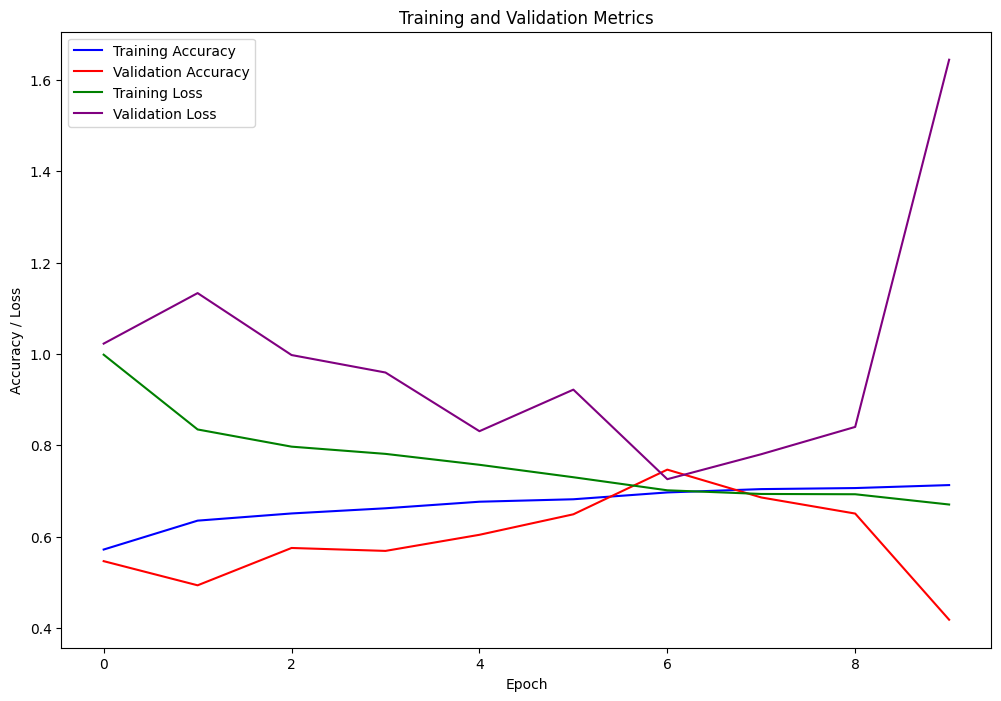

In [13]:
# Plot training and validation metrics
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.plot(history.history['loss'], label='Training Loss', color='green')
plt.plot(history.history['val_loss'], label='Validation Loss', color='purple')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.title('Training and Validation Metrics')
plt.show()

In [14]:
# Generate predictions
predictions = model1.predict(test_set, steps=len(test_set))
y_pred_classes = np.argmax(predictions, axis=1)
y_true = test_set.classes

39/39 [==============================] - 10s 249ms/step


In [20]:
# Compute and print classification metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(classification_report(y_true, y_pred_classes, target_names=test_set.class_indices.keys()))



Accuracy: 0.4183
Precision: 0.7110
Recall: 0.4183
F1-score: 0.2821
              precision    recall  f1-score   support

    bacteria       0.40      1.00      0.57       242
      normal       0.93      0.06      0.10       234
       viral       0.88      0.05      0.09       148

    accuracy                           0.42       624
   macro avg       0.73      0.37      0.26       624
weighted avg       0.71      0.42      0.28       624



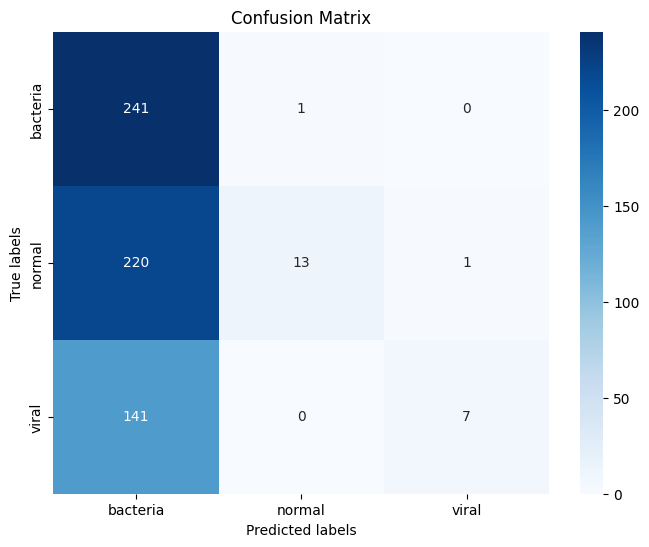

In [19]:
import seaborn as sns 
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_set.class_indices.keys(), yticklabels=test_set.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


1/1 [==============================] - 0s 401ms/step


C:\Users\avash\AppData\Local\Temp\ipykernel_11828\2103412566.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap(colormap)


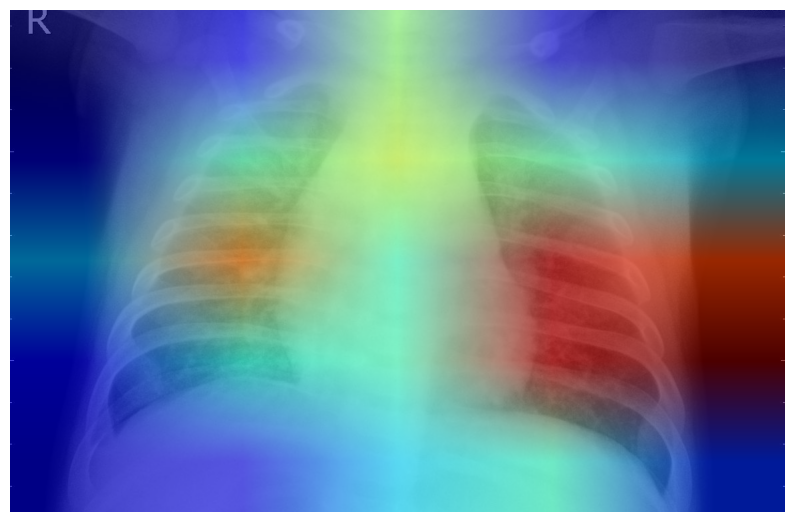

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2

# Load the pre-trained model
modelPath= r"D:\Class\Notes\Sem 6th\pneumonia_detection_CNN-master\flask\static\model84.hdf5"

model = tf.keras.models.load_model(modelPath)

# Function to get the Grad-CAM model
def get_grad_cam_model(model, layer_name):
    grad_model = Model(inputs=[model.inputs], outputs=[model.get_layer(layer_name).output, model.output])
    return grad_model

# Function to compute Grad-CAM
def compute_grad_cam(input_image, grad_model, class_idx):
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(input_image)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap  # Remove .numpy() since it's already a NumPy array

# Function to overlay heatmap on the original image
def overlay_heatmap(heatmap, original_image, alpha=0.4, colormap='jet'):
    heatmap = np.uint8(255 * heatmap)
    colormap = plt.cm.get_cmap(colormap)
    colormap = colormap(np.arange(256))[:, :3]
    colormap = colormap * 255
    colormap = np.uint8(colormap)
    heatmap = colormap[heatmap]

    heatmap = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
    overlay = cv2.addWeighted(original_image, alpha, heatmap, 1 - alpha, 0)
    return overlay

# Load and preprocess the image
img_path = r"D:\Class\Notes\Sem 6th\pneumonia_detection_CNN-master\data\chest_xray\train\viral\person153_virus_304.jpeg"
img = image.load_img(img_path, target_size=(150, 150))  # Resize to the expected input shape
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

# Get the layer name of the last convolutional layer
layer_name = 'conv2d_9'  # Replace with the actual layer name
grad_cam_model = get_grad_cam_model(model, layer_name)

# Make predictions and get the class index
predictions = model.predict(img_array)
class_idx = np.argmax(predictions[0])

# Compute the Grad-CAM heatmap
heatmap = compute_grad_cam(img_array, grad_cam_model, class_idx)

# Load the original image (without resizing for overlay)
original_img = cv2.imread(img_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Overlay the heatmap on the original image
overlay = overlay_heatmap(heatmap, original_img)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(overlay)
plt.axis('off')
plt.show()


In [17]:
FOR virdis Colormap Yellow: Highest activation
Green: Moderate activation
Purple: Lowest activation

using the jet colormap:

Red: Highest activation
Yellow: High activation
Green: Moderate activation
Blue: Low activation

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1779579717.py, line 1)

In [ ]:
import numpy as np
from tensorflow.keras.models import Model

def get_heatmap(img, pred_label):
    """
    Get the class activation map (CAM) heatmap for the given image and prediction label.

    Args:
        img (np.ndarray): The input image as a numpy array.
        pred_label (int): The prediction label for the input image.

    Returns:
        np.ndarray: The class activation map heatmap.
    """
    # Load the pre-trained model
    cam_model = Model(inputs=model.inputs, outputs=(model.get_layer('conv_output').output, model.output))

    # Preprocess the input image
    img_preprocessed = preprocess_image(img)

    # Get the feature map and predictions from the model
    conv_output, predictions = cam_model.predict(img_preprocessed)

    # Get the weights of the final dense layer
    weights = model.layers[-1].get_weights()[0][:, pred_label]

    # Reshape the weights to match the feature map dimensions
    weights = np.expand_dims(weights, axis=(1, 2))
    weights = np.repeat(weights, conv_output.shape[1], axis=1)
    weights = np.repeat(weights, conv_output.shape[2], axis=2)

    # Compute the class activation map heatmap
    heatmap = np.sum(conv_output[0] * weights, axis=-1)

    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

    return heatmap

# Load the image and preprocess it
sample_image = load_image('path/to/image.jpg')
sample_image_processed = preprocess_image(sample_image)

# Get the prediction label for the image
pred_label = np.argmax(model.predict(sample_image_processed))

# Get the class activation map heatmap
heatmap = get_heatmap(sample_image_processed, pred_label)

1/1 [==============================] - 0s 385ms/step


NameError: name 'weights' is not defined

In [13]:
import os
import cv2
import numpy as np
# Load the pre-trained model
from keras.models import load_model
model_path= r"D:\Class\Notes\Sem 6th\pneumonia_detection_CNN-master\flask\static\model84.hdf5"
model1 = load_model(model_path)

# get the label predicted by our original model
pred_label = np.argmax(model1.predict(sample_image_processed), axis=-1)[0]

# get the heatmap for class activation map(CAM)
heatmap = get_heatmap(sample_image_processed, pred_label)

image_path = r"D:\Class\Notes\Sem 6th\pneumonia_detection_CNN-master\data\chest_xray\train\bacteria\person7_bacteria_24.jpeg"
sample_image = cv2.imread(image_path)

# Pre-process the image
sample_image = cv2.resize(sample_image, (224, 224))
# Rest of the code...
if sample_image.shape[2] ==1:
            sample_image = np.dstack([sample_image, sample_image, sample_image])
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
sample_image = sample_image.astype(np.float32)/255.
sample_label = 1
    
    
sample_image_processed = np.expand_dims(sample_image, axis=0)#since we pass only one image,we expand dim to include
                                                             #batch size 1
    
# get the label predicted by our original model
pred_label = np.argmax(model1.predict(sample_image_processed), axis=-1)[0]
    
    
# get the heatmap for class activation map(CAM)
heatmap = get_heatmap(sample_image_processed, pred_label)
heatmap = cv2.resize(heatmap, (sample_image.shape[0], sample_image.shape[1]))
heatmap = heatmap *255
heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
#superimpose the heatmap on the image    

sample_image_hsv = color.rgb2hsv(sample_image)
heatmap = color.rgb2hsv(heatmap)

alpha=0.7
sample_image_hsv[..., 0] = heatmap[..., 0]
sample_image_hsv[..., 1] = heatmap[..., 1] * alpha

img_masked = color.hsv2rgb(sample_image_hsv)

f,ax = plt.subplots(1,2, figsize=(16,6))
ax[0].imshow(sample_image)
ax[0].set_title(f"True label: {sample_label} \n Predicted label: {pred_label}")
ax[0].axis('off')
    
ax[1].imshow(img_masked)
ax[1].set_title("Class Activation Map")
ax[1].axis('off')

plt.show()

ValueError: in user code:

    File "d:\Class\Notes\Sem 6th\pneumonia_detection_CNN-master\.venv\lib\site-packages\keras\src\engine\training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "d:\Class\Notes\Sem 6th\pneumonia_detection_CNN-master\.venv\lib\site-packages\keras\src\engine\training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\Class\Notes\Sem 6th\pneumonia_detection_CNN-master\.venv\lib\site-packages\keras\src\engine\training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "d:\Class\Notes\Sem 6th\pneumonia_detection_CNN-master\.venv\lib\site-packages\keras\src\engine\training.py", line 2381, in predict_step
        return self(x, training=False)
    File "d:\Class\Notes\Sem 6th\pneumonia_detection_CNN-master\.venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "d:\Class\Notes\Sem 6th\pneumonia_detection_CNN-master\.venv\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 150, 150, 3), found shape=(None, 224, 224, 3)


In [4]:
# Augmentation configuration to be used while training
train_generator = ImageDataGenerator(
                            rotation_range=20,
                            width_shift_range=0.25,
                            height_shift_range=0.25,
                            rescale=1./255,
                            shear_range=0.25,
                            zoom_range=0.25,
                            horizontal_flip=True,
                            fill_mode='nearest'
                            )

I will resize images to 224x224 px value and turn them to grayscale to only save the brightness and get rid of RGB values as the images are alrady provided as grayscale. It will help the train process run faster.


In [5]:
train_set = DirectoryIterator(train_dir,
                             train_generator,
                             target_size = (224, 224),
                             color_mode = 'rgb',
                             batch_size = 16,
                             classes=classes,
                             class_mode = 'categorical')

Found 5232 images belonging to 3 classes.


In [6]:
# Augmentation configuration to be used for validation
test_generator = ImageDataGenerator(rescale=1./255)

In [7]:
test_set = DirectoryIterator(test_dir,
                             test_generator,
                             target_size = (224, 224),
                             color_mode = 'rgb',
                             batch_size = 16, # set batch size a number that divides sample size
                             classes=classes,
                             class_mode = 'categorical')

Found 624 images belonging to 3 classes.


In [8]:
# Tensor size of train images
train_set.image_shape

(224, 224, 3)

In [9]:
# Tensor size of test images
test_set.image_shape

(224, 224, 3)

In [10]:
train_size = len(train_set.filenames)
test_size = len(test_set.filenames)

In [11]:
train_size, test_size

(5232, 624)

## Model #1 Dense

I will start with a simple sequential model and increase the complexity with based on the results we get from each iteration

In [12]:
# Initialize the sequential model
model1 = Sequential()

# Add flatten layer as input layer
model1.add(Flatten(input_shape = train_set.image_shape))

# Add a second densely-connected layer 
model1.add(Dense(units = 1024,
                activation='relu'))

# Add regularization
model1.add(Dropout(rate = 0.20))

# Add output layer
model1.add(Dense(units = 3,
    activation='softmax'
))

In [13]:
# Define optimizer
opt = SGD(lr=0.01)

In [14]:
# Compile the first model
model1.compile(optimizer = opt,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [15]:
# Define early stopping
early_stopping_monitor = EarlyStopping(patience = 5, 
                                       monitor = "val_accuracy", 
                                       mode="max", 
                                       verbose = 2)

# Define batch size (a divisor of test sample size)
batch_size = 16

In [16]:
# Fit model on training data
history = model1.fit_generator(generator = train_set,
                              validation_data = test_set,
                              epochs = 10,
#                               callbacks=[early_stopping_monitor],
                              steps_per_epoch = train_size/batch_size, 
                              validation_steps = test_size/batch_size,
                              shuffle=False,
                              verbose = 2)

Epoch 1/10
327/327 - 231s - loss: 8.2893 - accuracy: 0.4838 - val_loss: 9.8672 - val_accuracy: 0.3878
Epoch 2/10
327/327 - 244s - loss: 8.2993 - accuracy: 0.4851 - val_loss: 9.8672 - val_accuracy: 0.3878
Epoch 3/10
327/327 - 261s - loss: 8.2993 - accuracy: 0.4851 - val_loss: 9.8672 - val_accuracy: 0.3878
Epoch 4/10
327/327 - 239s - loss: 8.2993 - accuracy: 0.4851 - val_loss: 9.8672 - val_accuracy: 0.3878
Epoch 5/10
327/327 - 240s - loss: 8.2993 - accuracy: 0.4851 - val_loss: 9.8672 - val_accuracy: 0.3878
Epoch 6/10
327/327 - 236s - loss: 8.2993 - accuracy: 0.4851 - val_loss: 9.8672 - val_accuracy: 0.3878
Epoch 7/10
327/327 - 222s - loss: 8.2993 - accuracy: 0.4851 - val_loss: 9.8672 - val_accuracy: 0.3878
Epoch 8/10
327/327 - 208s - loss: 8.2993 - accuracy: 0.4851 - val_loss: 9.8672 - val_accuracy: 0.3878
Epoch 9/10
327/327 - 210s - loss: 8.2993 - accuracy: 0.4851 - val_loss: 9.8672 - val_accuracy: 0.3878
Epoch 10/10
327/327 - 212s - loss: 8.2993 - accuracy: 0.4851 - val_loss: 9.8672 - 

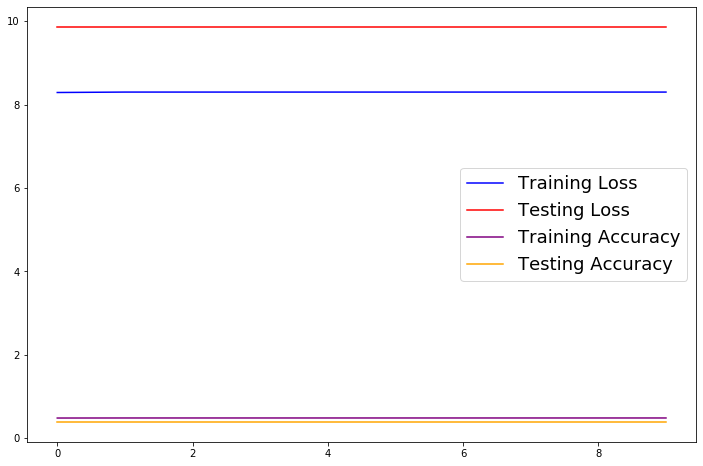

In [17]:
# Check out our train loss & accuracy and test loss & accuracy over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

# Generate line plot of training, testing loss & accuracy over epochs.
plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(test_loss, label='Testing Loss', color='red')
plt.plot(train_accuracy, label='Training Accuracy', color='purple')
plt.plot(test_accuracy, label='Testing Accuracy', color='orange')
plt.legend(fontsize = 18);

In [18]:
predictions = model1.predict_generator(generator = test_set, 
                                       verbose = 2,
                                       steps = test_size/batch_size
                                      )

39/39 - 8s


In [19]:
y_hat = np.argmax(predictions, axis = 1) 
y_true = test_set.classes

In [20]:
len(y_true) == len(y_hat)

True

In [21]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

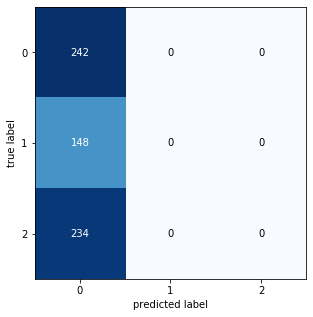

In [22]:
CM = confusion_matrix(y_true, y_hat)
fig, ax = plot_confusion_matrix(conf_mat=CM,  figsize=(5, 5))
plt.show()

My first model had five dense layers with very few neurons. It performed terrible with no predictive capability as all images were classified as bacterial pneumonia (majority class). I removed all additional dense layers and kept only one with large number of neurons which did not make any change. It seems like we can't get away without convolutional layers in such a large input size.

## Model #2 Simple CNN

In [28]:
# Initialize the sequential model
model2 = Sequential()

# Add convolution and pooling as input layer
model2.add(Conv2D(filters = 32, # number of filters
                 kernel_size = (3, 3), # height/width of filter
                 input_shape = train_set.image_shape, # shape of input (image)
                 activation = 'relu')) # activation function

model2.add(MaxPooling2D(pool_size = (2, 2))) # dimensions of region of pooling

# Add a second convolutional layer
model2.add(Conv2D(filters = 32, 
                 kernel_size = (3, 3),
                 activation = 'relu'))

model2.add(MaxPooling2D(pool_size = (2, 2)))

# Add a flattening layer
model2.add(Flatten())

# Add a densely-connected layer
model2.add(Dense(units = 128,
                activation = 'relu'))

# Add output layer
model2.add(Dense(units = 3,
                activation = 'sigmoid'))

In [29]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 93312)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               11944064  
_________________________________________________________________
dense_5 (Dense)              (None, 3)                

In [30]:
model2.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [31]:
# Fit model on training data
history = model2.fit_generator(generator = train_set,
                              validation_data = test_set,
                              epochs = 10,
                              callbacks=[early_stopping_monitor],
                              steps_per_epoch = train_size/batch_size, 
                              validation_steps = test_size/batch_size,
                              shuffle = True,
                              verbose = 2)

Epoch 1/10
327/327 - 262s - loss: 0.5500 - accuracy: 0.7427 - val_loss: 0.6414 - val_accuracy: 0.7158
Epoch 2/10
327/327 - 287s - loss: 0.4778 - accuracy: 0.7791 - val_loss: 0.5886 - val_accuracy: 0.7580
Epoch 3/10
327/327 - 276s - loss: 0.4750 - accuracy: 0.7819 - val_loss: 0.5115 - val_accuracy: 0.7724
Epoch 4/10
327/327 - 283s - loss: 0.4617 - accuracy: 0.7892 - val_loss: 0.4703 - val_accuracy: 0.7965
Epoch 5/10
327/327 - 286s - loss: 0.4452 - accuracy: 0.7961 - val_loss: 0.5571 - val_accuracy: 0.7553
Epoch 6/10
327/327 - 287s - loss: 0.4374 - accuracy: 0.8010 - val_loss: 0.5285 - val_accuracy: 0.7853
Epoch 7/10
327/327 - 296s - loss: 0.4263 - accuracy: 0.8078 - val_loss: 0.4447 - val_accuracy: 0.8136
Epoch 8/10
327/327 - 294s - loss: 0.4330 - accuracy: 0.8038 - val_loss: 0.4449 - val_accuracy: 0.8189
Epoch 9/10
327/327 - 298s - loss: 0.4210 - accuracy: 0.8078 - val_loss: 0.4221 - val_accuracy: 0.8285
Epoch 10/10
327/327 - 390s - loss: 0.4105 - accuracy: 0.8120 - val_loss: 0.4033 - 

## Model #3 - Pre-trained Model (VGG16 Convolutional Base)

I decided to use the artichecture of a pre-trained model as I was curious about transfer learning outcome. Transfer learning is using a pre-trained model and/or its weights on a different dataset. I chose to use the arthitecture of VGG16 convolutional neural network which is popular from ImageNet competition. This allowed me to save time for inital checking the capability of my data without requiring vast amount of hyperparameter tunning and optimizing.

In [ ]:
# base_model = VGG16(weights = 'imagenet', 
#                  include_top = False,
#                  input_shape = train_set.image_shape)

In [ ]:
# VGG16 Arthitecture

model = Sequential()
model.add(Conv2D(input_shape=train_set.image_shape, filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=2, activation="sigmoid"))

In [ ]:
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
checkpoint = ModelCheckpoint("vgg16.h5", monitor='accuracy', verbose=1, save_best_only=True, 
                             save_weights_only=False, mode='max', save_freq=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

In [ ]:
history = model.fit_generator(steps_per_epoch=100,
                              generator=train_set, 
                              validation_data=test_set, 
                              validation_steps=10,
                              epochs=25,
                              callbacks=[checkpoint,early])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()